In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [2]:
def plot_error(abs_error, rel_error, k, update_times):
    """Plot absolute and relative error"""
    plt.xticks(range(0, k, 5))
    plt.title('Error across queries:')
    rel_line, = plt.plot(rel_error, label='Relative Error')
    abs_line, = plt.plot(abs_error, label='Absolute Error')
    for xc in update_times:
        plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
    plt.legend(handles=[rel_line, abs_line])

In [3]:
def pmw(workload, x, eps=13, beta=0.1, laplace_scale=1):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """
    def print_outputs():
        # input
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
                
        # create pandas dataframe
        d = {
                'workloads': workload.tolist(), 
                'd_t_hat': d_t_hat_list, 
                'updated': update_list,
                'algo_ans': algo_answers,
                'real_ans': real_ans.tolist(),
                'abs_error': abs_error,
                'rel_error': rel_error,
             }
        df = pd.DataFrame(data=d)
        display(df)
        

    # initialize constants
    m = x.size  # database len
    n = x.sum()  # database sum
    k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = math.log(m, np.e) ** (1 / 4) / math.sqrt(n)
    sigma = 10 * math.log(1 / delta, np.e) * (math.log(m, np.e)) ** (1 / 4) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    y_list = [y_t]
    x_list = [x_t]
    
    update_list = []
    algo_answers = []
    update_times = []
    d_t_hat_list = []
    # iterate through time = (0, k)
    for time, query in enumerate(workload):

        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=laplace_scale, size=1)[0]
        a_t_hat = np.dot(query, x_norm) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - np.dot(query, x_list[time])
        d_t_hat_list.append(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold:
            algo_answers.append(np.dot(query, x_list[time]))
            x_list.append(x_list[time])
            update_list.append('no')
            continue

        # update round: update histogram and return noisy answer
        else:
            update_list.append('yes')
            update_times.append(time)

            # step a
            if d_t_hat > 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            y_list.append(y_t)

            # step b
            x_t = y_t / np.sum(y_t)
            x_list.append(x_t)
        
        update_count = update_list.count('yes')

        if update_count > n * math.log(m, 10) ** (1 / 2):
            return "failure"
        else:
            algo_answers.append(a_t_hat / np.sum(x))

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(algo_answers - real_ans)
    rel_error = np.abs(algo_answers / np.where(real_ans == 0, 0.000001,
                                                real_ans))

    print_outputs()
    plot_error(abs_error, rel_error, k, update_times)


In [4]:
x_peaks = np.array([1000, 8000, 1300, 1250, 9000, 1450, 1700, 1720])
W_allrange = workload.AllRange(8).dense_matrix()

Original database: [1000 8000 1300 1250 9000 1450 1700 1720]

Normalized database: [0.0393391  0.31471282 0.05114083 0.04917388 0.35405193 0.0570417
 0.06687648 0.06766326]

Updated Database = [0.12428375 0.12428375 0.12242561 0.12335118 0.12522336 0.12522336
 0.12808504 0.12712395]

Update Count = 11

threshold=1.6996721141306268



,workloads,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.105990,no,0.125000,0.039339,0.085661,3.177500
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.555959,no,0.250000,0.354052,0.104052,0.706111
2,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.543852,no,0.375000,0.405193,0.030193,0.925485
3,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-1.118427,no,0.500000,0.454367,0.045633,1.100433
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]",-1.857847,yes,-0.000048,0.808419,0.808467,0.000060
5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]",1.953455,yes,0.000106,0.865460,0.865354,0.000123
6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",0.437076,no,0.874883,0.932337,0.057454,0.938376
7,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.305299,no,1.000000,1.000000,0.000000,1.000000
8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.034529,no,0.125117,0.314713,0.189595,0.397560
9,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.091437,no,0.250235,0.365854,0.115619,0.683975


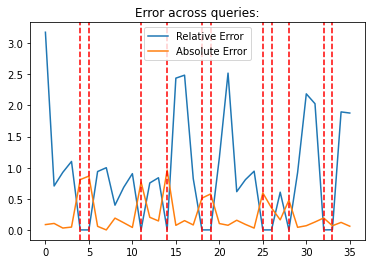

In [5]:
pmw(W_allrange, x_peaks, eps=13)

The updated database and the original normalized database are really different. Furthermore, the relative error is extremely high (3 and 2.5-fold), which is abnormal. The relative error should definitely be decently below 1. The database needs to update more. 

In [6]:
query_a = np.array([[1,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0]])

query_b = np.array([[0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0]])

In [7]:
pmw(query_a, x_peaks, eps=13)

Original database: [1000 8000 1300 1250 9000 1450 1700 1720]

Normalized database: [0.0393391  0.31471282 0.05114083 0.04917388 0.35405193 0.0570417
 0.06687648 0.06766326]

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]



NameError: free variable 'update_count' referenced before assignment in enclosing scope

In [ ]:
pmw(np.vstack((query_a, query_b)), x_peaks, eps=0.01)